**Instructions**

	1.	Find a dataset on Kaggle that you find interesting.
	2.	Open a clean Jupyter notebook.
	3.	Explore the dataset.
	4.	Clean the dataset.
	5.	Create some analyses.
	6.	Engineer new features.
	7.	Develop an ML model.
	8.	Make a prediction.
While working through this, consider pushing your progress to a new GitHub repo using the terminal, and don’t forget to write a comprehensive README.md file.

# Women's International Football 

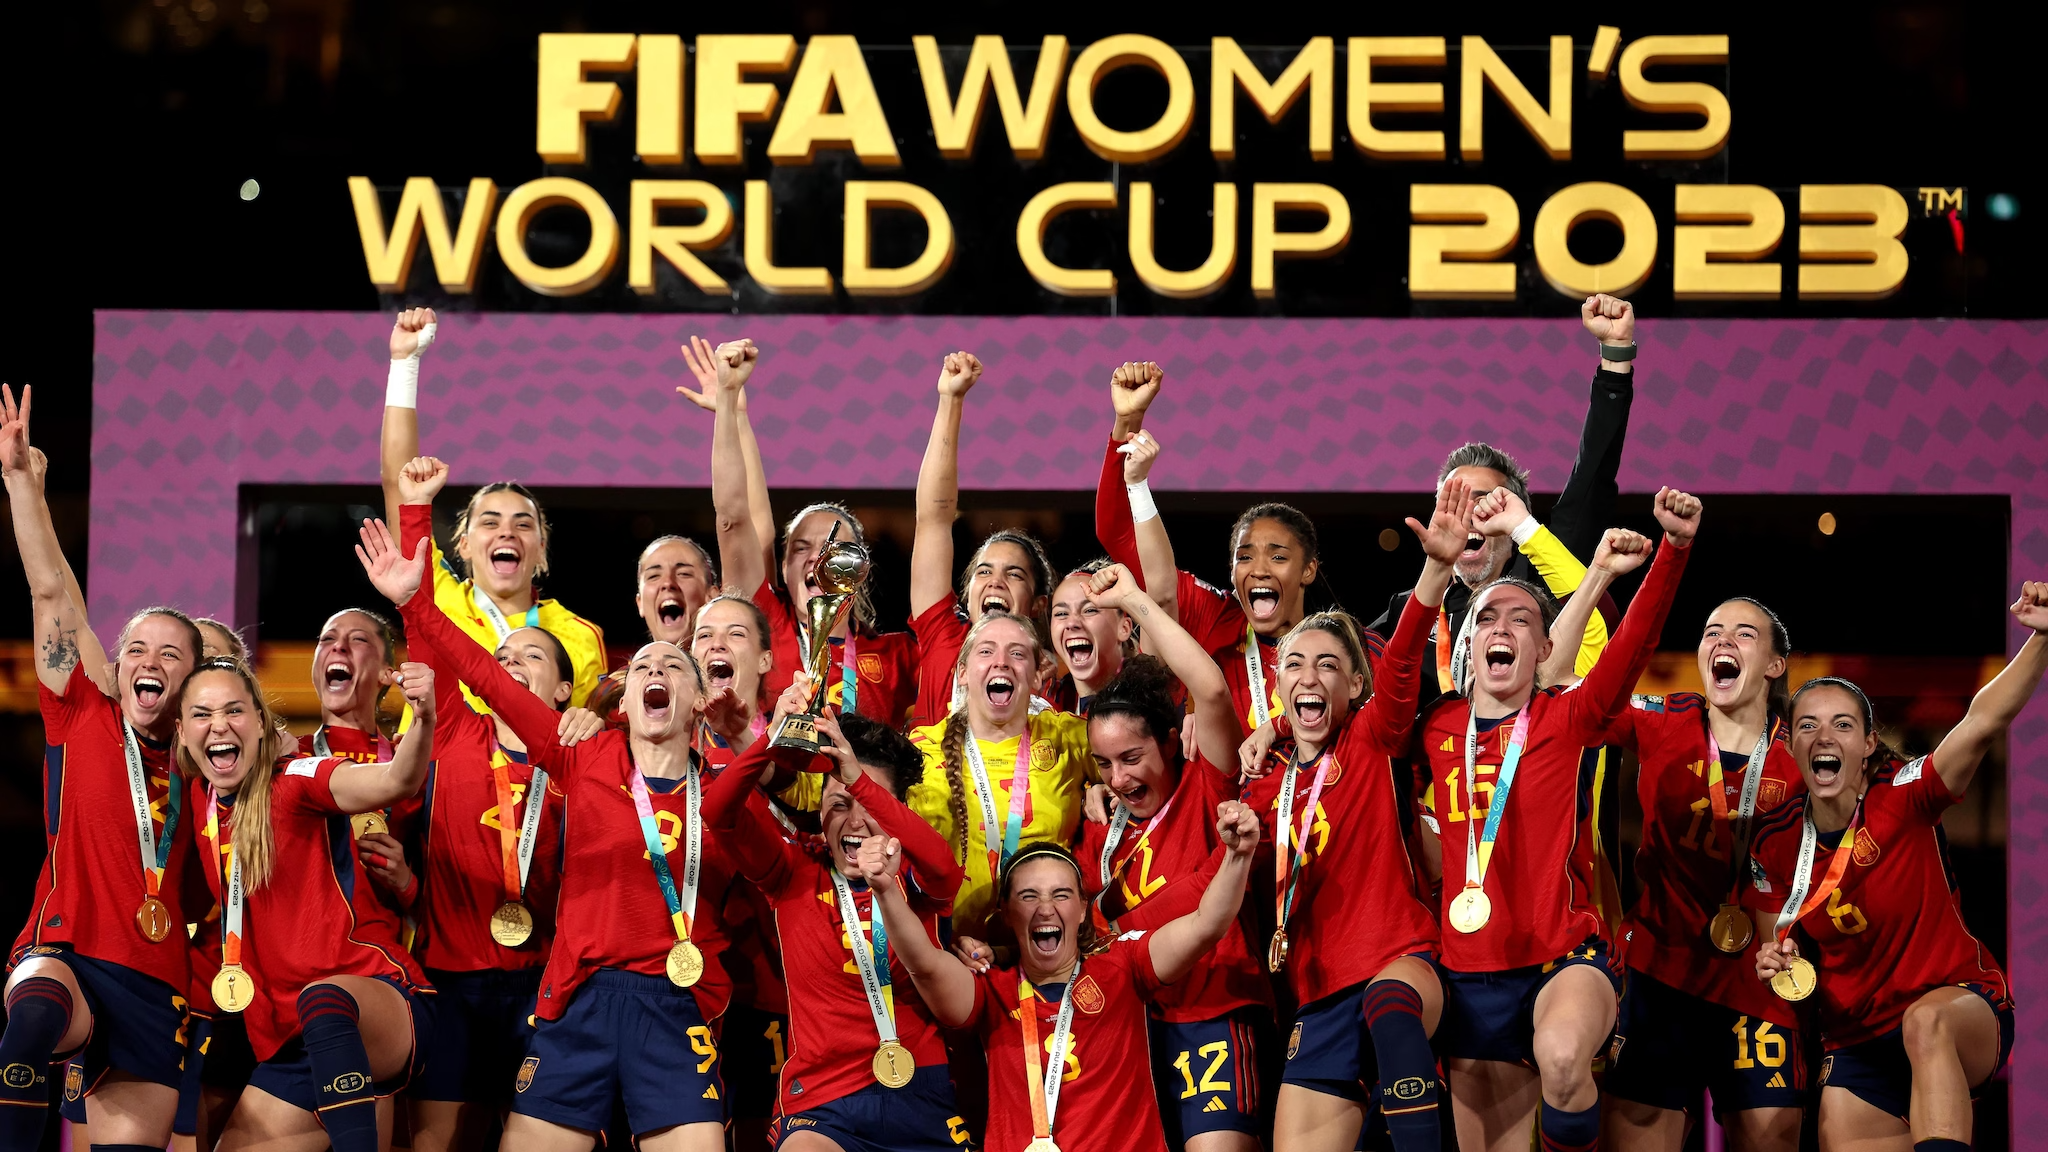

In [1]:
from IPython.display import Image, display



# Display an image
display(Image(filename='world_cup.png'))

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load the dataset and data discovery

In [3]:
abs_path = os.getcwd() # gets you the abs path to current working directory

In [4]:
csv_path = os.path.join(abs_path, 'womens-international-football-results')

In [5]:
df = pd.read_csv(os.path.join(csv_path, 'results.csv'))
df.head()

date    home_team    away_team  home_score  away_score  \
0  1956-09-23      Germany  Netherlands         2.0         1.0   
1  1957-07-28      Germany      England         1.0         1.0   
2  1957-10-13      Germany  Netherlands         2.0         0.0   
3  1957-11-03  Netherlands      Austria         8.0         1.0   
4  1957-11-03      Germany      England         0.0         4.0   

              tournament       city  country  neutral  
0               Friendly      Essen  Germany    False  
1               Friendly  Stuttgart  Germany    False  
2               Friendly     Berlin  Germany    False  
3  European Championship     Berlin  Germany     True  
4  European Championship     Berlin  Germany    False

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        9830 non-null   object 
 1   home_team   9830 non-null   object 
 2   away_team   9830 non-null   object 
 3   home_score  9828 non-null   float64
 4   away_score  9828 non-null   float64
 5   tournament  9830 non-null   object 
 6   city        9829 non-null   object 
 7   country     9829 non-null   object 
 8   neutral     9830 non-null   bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 624.1+ KB


In [7]:
len(df)

9830

## Data cleaning

### Duplicates

In [8]:
# Checking if there are any duplicates
df.duplicated().sum()

0

### Missing data

In [9]:
# Counting the number of NaN values for each column
df.isnull().sum().sort_values(ascending=False)

home_score    2
away_score    2
city          1
country       1
date          0
home_team     0
away_team     0
tournament    0
neutral       0
dtype: int64

In [10]:
# Counting the percentage of NaN for each column
df.isnull().sum().sort_values(ascending=False)/len(df)

home_score    0.000203
away_score    0.000203
city          0.000102
country       0.000102
date          0.000000
home_team     0.000000
away_team     0.000000
tournament    0.000000
neutral       0.000000
dtype: float64

In [11]:
# We check what values are missing
df[df.isna().any(axis=1)]

date     home_team  away_team  home_score  away_score  \
9551  2024-06-04       Belarus  Lithuania         3.0         0.0   
9828  2024-12-07     Australia     Taiwan         NaN         NaN   
9829  2024-12-07  Saudi Arabia   Pakistan         NaN         NaN   

                   tournament     city    country  neutral  
9551  UEFA Euro qualification      NaN        NaN    False  
9828                 Friendly  Geelong  Australia    False  
9829                 Friendly     Doha      Qatar     True

Initially I wanted to drop the missing values as the percentage is tiny but I found the results online so I just updated them.

In [12]:
df.loc[9828, 'home_score':'away_score'] = [6.0, 0.0]

In [13]:
df.loc[9829, 'home_score':'away_score'] = [1.0, 1.0]

Doing some research, I realised that the Belarus - Lithuania game did not take place as Lithuania refused to play Belarus because of their support to Russia.

[More information](https://www.nytimes.com/athletic/5539636/2024/06/04/lithuania-belarus-womens-euro-2025/)

I decided to drop this row as I couldn't find where the game should have taken place.

In [14]:
df.dropna(subset=['city'], inplace=True)

We check that there are no missing values now

In [15]:
df.isnull().sum().sort_values(ascending=False)

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [16]:
len(df)

9829

### Outliers

<AxesSubplot:xlabel='home_score'>

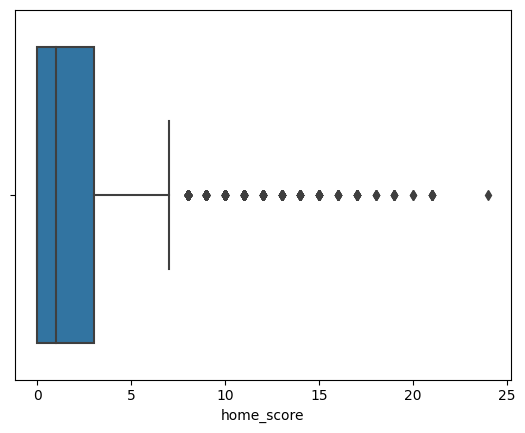

In [17]:
sns.boxplot(x='home_score', data=df)

<AxesSubplot:xlabel='away_score'>

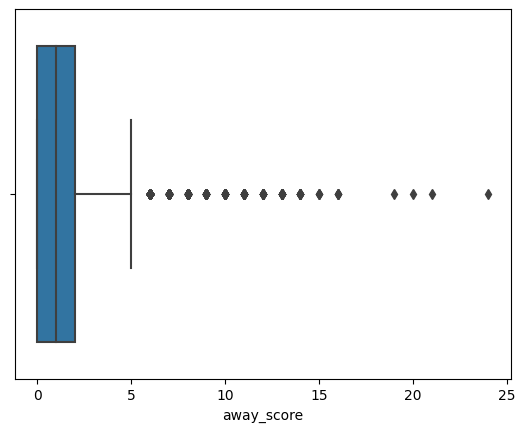

In [18]:
sns.boxplot(x='away_score', data=df)

In [19]:
df['away_score'].max()

24.0

There are outliers but for now, I'll keep them in the dataset.

In [20]:
df.head(5)

date    home_team    away_team  home_score  away_score  \
0  1956-09-23      Germany  Netherlands         2.0         1.0   
1  1957-07-28      Germany      England         1.0         1.0   
2  1957-10-13      Germany  Netherlands         2.0         0.0   
3  1957-11-03  Netherlands      Austria         8.0         1.0   
4  1957-11-03      Germany      England         0.0         4.0   

              tournament       city  country  neutral  
0               Friendly      Essen  Germany    False  
1               Friendly  Stuttgart  Germany    False  
2               Friendly     Berlin  Germany    False  
3  European Championship     Berlin  Germany     True  
4  European Championship     Berlin  Germany    False

In [76]:
# Update the results that are wrong for the first EURO's final (I use this later in my notebook)
df.loc[213, 'home_score'] = [3.0]
df.loc[213, 'away_score'] = [4.0]

## Data transformation

In [22]:
df.dtypes

date           object
home_team      object
away_team      object
home_score    float64
away_score    float64
tournament     object
city           object
country        object
neutral          bool
dtype: object

Let's change the date column into a datetime datatype.

In [23]:
df['date'] = pd.to_datetime(df['date'])

We create a year column to then plot games per year.

In [24]:
df['year'] = df['date'].dt.year

I would like to compute two columns that have a 1.0 if it was a home_victory and another one that has a 1.0 if it was an away victory

In [25]:
df['home_victory'] = (df['home_score'] > df['away_score']).astype(np.int64)
df['away_victory'] = (df['home_score'] < df['away_score']).astype(np.int64)

Instead of Trues and Falses, I want the 'neutral' column to have 1s and 0s

In [26]:
df['neutral'] = df['neutral'].astype(np.int64)

## Data analysis

I'm going to analyse:

1. The evolution of women's international games based on how many games were played each year
2. The best team of all times based on number of wins
3. A deep dive into Spain's performance in the FIFA World Cup and UEFA European Women's Championship
4. Which country has won more UEFA European Women's Championship?
5. Engineer some features and create a Machine Learning model to predict who will win a game. It will be a classification task using a logistic regression.


### Evolution of women's international games

In [27]:
games_py = df.groupby('year')['date'].count().reset_index()
games_py.rename(columns={'date':'games'}, inplace=True)
games_py.head(5)

year  games
0  1956      1
1  1957      4
2  1969      4
3  1970      8
4  1971     11

In [28]:
# Finding the max number of games played in a year
games_py.sort_values(by='games', ascending=False).iloc[0]

year     2023
games     700
Name: 55, dtype: int64

In [29]:
# Another way of doing it
games_py.loc[games_py['games'].idxmax()]


year     2023
games     700
Name: 55, dtype: int64

Let´s visualise it with Seaborn and Matplotlib

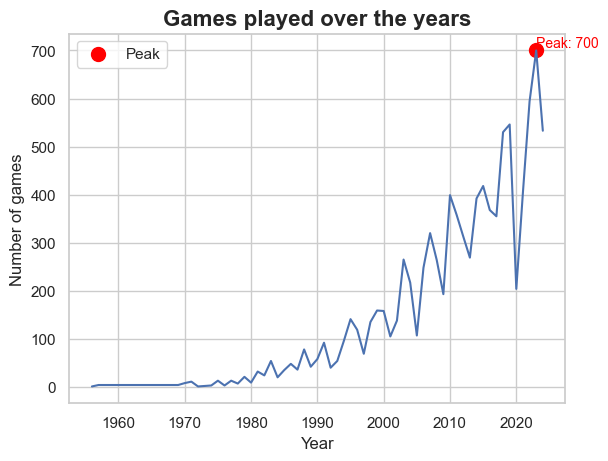

In [30]:
#Clean style
sns.set(style="whitegrid")

sns.lineplot(x='year', y='games', data=games_py)

plt.title("Games played over the years", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of games", fontsize=12)

# Find the max value
max_games = games_py.loc[games_py['games'].idxmax()]
plt.text(max_games['year'], max_games['games'], f"Peak: {max_games['games']}",
         fontsize=10, ha='left', va='bottom', color='red')

plt.scatter(max_games['year'], max_games['games'], color='red', s=100, label="Peak")
plt.legend()


Now, let's visualise it with plotly express.

In [77]:
# Create the line plot with plotly express
fig = px.line(games_py, x='year', y='games', title="Games Played Over the Years",
              labels={'year': 'Year', 'games': 'Number of Games'}, template='plotly_white')

# Find the max value
max_games = games_py.loc[games_py['games'].idxmax()]

# Add a scatter point for the peak
fig.add_scatter(x=[max_games['year']], y=[max_games['games']], mode='markers+text',
                text=[f"Peak: {max_games['games']}"], textposition='top left',
                marker=dict(color='red', size=12), name='Peak')

# Show the plot
fig.show()


We can clearly see an increase of international games played throughout the years as women's football has been on the rise.

It reached a max of 700 games in 2023 and the dataset does not provide data for all the games played in 2024 yet.

You can see fluctuations every couple of years due to major events frequency (e.g. World Cup and Euros) 

We see a clear drop in 2020 due to the Covid-19 pandemic.

### Best team of all times

In [32]:
df.head()

date    home_team    away_team  home_score  away_score  \
0 1956-09-23      Germany  Netherlands         2.0         1.0   
1 1957-07-28      Germany      England         1.0         1.0   
2 1957-10-13      Germany  Netherlands         2.0         0.0   
3 1957-11-03  Netherlands      Austria         8.0         1.0   
4 1957-11-03      Germany      England         0.0         4.0   

              tournament       city  country  neutral  year  home_victory  \
0               Friendly      Essen  Germany        0  1956             1   
1               Friendly  Stuttgart  Germany        0  1957             0   
2               Friendly     Berlin  Germany        0  1957             1   
3  European Championship     Berlin  Germany        1  1957             1   
4  European Championship     Berlin  Germany        0  1957             0   

   away_victory  
0             0  
1             0  
2             0  
3             0  
4             1

In [33]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year', 'home_victory',
       'away_victory'],
      dtype='object')

In [34]:
# Count wins for home and away teams: filter and group by
home_wins = df[df['home_victory'] == 1].groupby('home_team').size()
away_wins = df[df['away_victory'] == 1].groupby('away_team').size()

# Combine wins for home and away teams
total_wins = home_wins.add(away_wins, fill_value=0)

# Sort by wins
best_teams_by_wins = total_wins.sort_values(ascending=False)
print(best_teams_by_wins)

United States            453.0
Germany                  265.0
Sweden                   265.0
Norway                   250.0
China PR                 238.0
                         ...  
Serbia and Montenegro      1.0
Curacao                    1.0
Rhodes                     1.0
Saare County               1.0
Afghanistan                1.0
Length: 213, dtype: float64


In [35]:
best_teams_df = best_teams_by_wins.to_frame(name='wins')
best_teams_df.reset_index(inplace=True)
best_teams_df.rename(columns={'index': 'country'}, inplace=True)
top_15 = best_teams_df.sort_values(by='wins', ascending=False).head(15)

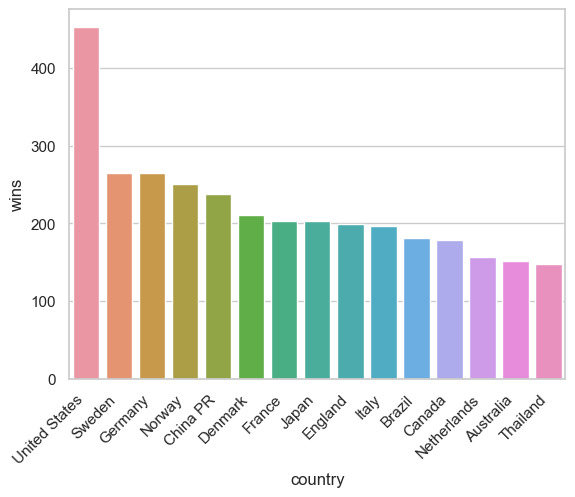

<Figure size 1000x600 with 0 Axes>

In [36]:
sns.barplot(x='country', y='wins', data=top_15)
# Rotate x-axis labels by 45 degrees to make them readable and align them to the right
plt.xticks(rotation=45, ha='right')

# Optional: Adjust plot size if necessary
plt.figure(figsize=(10, 6))

# Show the plot
plt.show()

In [37]:
# With plotly express

# Create the bar plot
fig = px.bar(top_15, x='country', y='wins', title='Top 15 Countries by Wins', color='country')

# Customize the layout to rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=45,  # Rotate x-axis labels by 45 degrees
    title=dict(font=dict(size=20), x=0.5),  # Center and style the title
    xaxis_title="Country",  # Add x-axis label
    yaxis_title="Wins",  # Add y-axis label
    font=dict(size=12),  # Set global font size
    plot_bgcolor='white',  # Set background color to white for a clean look
    bargap=0.2  # Adjust gap between bars for better aesthetics
)

# Display the plot
fig.show()

We can see a clear domination of the US football team which is not surprising. Football (or soccer) is a very popular game for women in the US, with lots of support and a professional league. With four titles, the United States is the most successful Women's World Cup team.

Exploring the best team ever based on largest amount of wins has limitations and it is also based on number of games played. 

We could have also explored the best teams by goal difference, or more goals scored.


### Deep dive: Spain in the FIFA World Cup and UEFA European Women's Championship

In [38]:
# Filter the DataFrame to keep only the results from those two competitions
filtered_df= df[(df['tournament']== 'FIFA World Cup') | (df['tournament']== 'UEFA Euro')]

In [39]:
filtered_df.head()

date home_team away_team  home_score  away_score tournament  \
208 1984-04-08   England   Denmark         2.0         1.0  UEFA Euro   
209 1984-04-08     Italy    Sweden         2.0         3.0  UEFA Euro   
210 1984-04-28   Denmark   England         0.0         1.0  UEFA Euro   
211 1984-04-28    Sweden     Italy         2.0         1.0  UEFA Euro   
212 1984-05-12    Sweden   England         1.0         0.0  UEFA Euro   

           city  country  neutral  year  home_victory  away_victory  
208       Crewe  England        0  1984             1             0  
209        Rome    Italy        0  1984             0             1  
210    Hjørring  Denmark        0  1984             0             1  
211   Linköping   Sweden        0  1984             1             0  
212  Gothenburg   Sweden        0  1984             1             0

In [40]:
# Spain's games on both competitionss
filtered_df['spain_played'] = ((filtered_df['home_team']== 'Spain') | (filtered_df['away_team']== 'Spain')).astype(np.int64)
filtered_df = filtered_df.drop(columns=['city', 'date', 'home_score', 'away_score'])
filtered_df.head()

/var/folders/gs/gknr8mgn1sv9wpgxwlstpqcw0000gn/T/ipykernel_11846/217348423.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



home_team away_team tournament  country  neutral  year  home_victory  \
208   England   Denmark  UEFA Euro  England        0  1984             1   
209     Italy    Sweden  UEFA Euro    Italy        0  1984             0   
210   Denmark   England  UEFA Euro  Denmark        0  1984             0   
211    Sweden     Italy  UEFA Euro   Sweden        0  1984             1   
212    Sweden   England  UEFA Euro   Sweden        0  1984             1   

     away_victory  spain_played  
208             0             0  
209             1             0  
210             1             0  
211             0             0  
212             0             0

In [41]:
# Spain's appearances over each year
spain_appearances=filtered_df.groupby(by='year')['spain_played'].sum().reset_index()
# Plotting with Plotly Express
fig = px.line(
    spain_appearances,
    x='year',
    y='spain_played',
    title="Spain's Appearances Over the Years",
    labels={'year': 'Year', 'spain_played': 'Number of Appearances'},
    markers=True  # Add markers for each data point
)


fig.show()

This graph shows us the later adoption of professional women's football in Spain compared to other countries like the US. However, Spain has been playing more games across both competitions since 2015 showing that the team has made it further in both competitions with 2023 being a key year as they won the World Cup.

Let's see how Spain has performed in terms of wins.

In [42]:
spain_wins=filtered_df[filtered_df['spain_played']== 1].groupby(by='year').agg({'home_victory':'sum', 'away_victory':'sum'}).reset_index()
spain_wins['total_wins'] = spain_wins['home_victory'] + spain_wins['away_victory']
spain_wins= spain_wins.drop(columns=['home_victory','away_victory'])
spain_wins

year  total_wins
0  1997           3
1  2013           3
2  2015           2
3  2017           3
4  2019           3
5  2022           4
6  2023           7

<AxesSubplot:xlabel='year', ylabel='total_wins'>

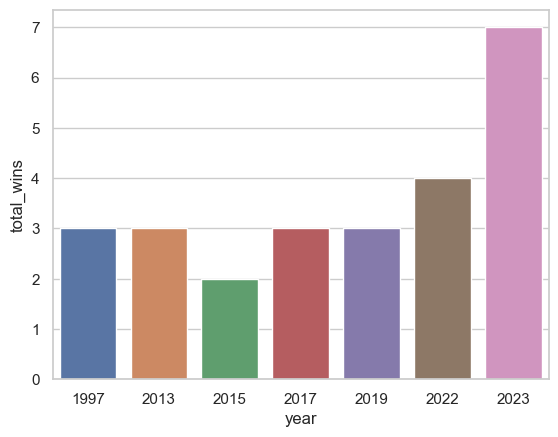

In [43]:
sns.barplot(x='year', y= 'total_wins', data= spain_wins)

It shows a similar pattern. Women's football in Spain took off in the 2010s and 2023 was the best year so far with the team winning the World Cup. 

Spain is one of five national teams to have been crowned world champions, having qualified three times for the FIFA Women's World Cup.

Let's see how they perform in the Euros in 2025.

### What team has won more UEFA Euros?

The last date of each tournament is usually the final so that's what we are interested in. I'll double check each result to see if it's correct. The Euros are every four years. 

In [44]:
best_df= df[df['tournament']== 'UEFA Euro']
best_df

date home_team    away_team  home_score  away_score tournament  \
208  1984-04-08   England      Denmark         2.0         1.0  UEFA Euro   
209  1984-04-08     Italy       Sweden         2.0         3.0  UEFA Euro   
210  1984-04-28   Denmark      England         0.0         1.0  UEFA Euro   
211  1984-04-28    Sweden        Italy         2.0         1.0  UEFA Euro   
212  1984-05-12    Sweden      England         1.0         0.0  UEFA Euro   
...         ...       ...          ...         ...         ...        ...   
8432 2022-07-22    Sweden      Belgium         1.0         0.0  UEFA Euro   
8434 2022-07-23    France  Netherlands         1.0         0.0  UEFA Euro   
8444 2022-07-26   England       Sweden         4.0         0.0  UEFA Euro   
8448 2022-07-27   Germany       France         2.0         1.0  UEFA Euro   
8455 2022-07-31   England      Germany         2.0         1.0  UEFA Euro   

               city  country  neutral  year  home_victory  away_victory  
208           Crewe  England        0  1984             1             0  
209            Rome    Italy        0  1984             0             1  
210        Hjørring  Denmark        0  1984             0             1  
211       Linköping   Sweden        0  1984             1             0  
212      Gothenburg   Sweden        0  1984             1             0  
...             ...      ...      ...   ...           ...           ...  
8432          Leigh  England        1  2022             1             0  
8434      Rotherham  England        1  2022             1             0  
8444      Sheffield  England        0  2022             1             0  
8448  Milton Keynes  England        1  2022             1             0  
8455         London  England        0  2022             1             0  

[184 rows x 12 columns]

In [45]:
# Find the rows with the latest date for each year
winners_df = best_df.loc[best_df.groupby('year')['date'].idxmax()]
len(winners_df)

14

In [46]:
# Create a new column 'winner'
def determine_winner(row):
    if row['home_victory'] == 1:
        return row['home_team']  # Home team wins
    elif row['away_victory'] == 1:
        return row['away_team']  # Away team wins
    else:
        return 'Draw or mistake'  # Handle draw if both victories are 0

# Apply the function to the DataFrame
winners_df['winner'] = winners_df.apply(determine_winner, axis=1)


In [47]:
winners_df.head()

date home_team away_team  home_score  away_score tournament  \
213 1984-05-27   England    Sweden         3.0         4.0  UEFA Euro   
314 1987-06-14    Norway    Sweden         2.0         1.0  UEFA Euro   
435 1989-07-02   Germany    Norway         4.0         1.0  UEFA Euro   
578 1991-07-14   Denmark     Italy         2.0         1.0  UEFA Euro   
660 1993-07-04     Italy    Norway         0.0         1.0  UEFA Euro   

          city  country  neutral  year  home_victory  away_victory   winner  
213      Luton  England        0  1984             0             1   Sweden  
314       Oslo   Norway        0  1987             1             0   Norway  
435  Osnabrück  Germany        0  1989             1             0  Germany  
578    Aalborg  Denmark        0  1991             1             0  Denmark  
660     Cesena    Italy        0  1993             0             1   Norway

There are three mistakes. In 1984, Sweden won against England (penalties 3-4 to Sweden) and in 1991 Germany won 3-1 to Norway. The game was probably played before the game for the 3rd place which is the one that is displayed. 

The last mistake is that it also included the semifinal game in 1994 from which the finalists went on to play in 1995.

In [78]:
# I updated the columns that are wrong for the first mistake in the whole dataset and I moved this to the beginning of my notebook. I put the result after penalties to avoid it saying draw.

In [49]:
# In the winners_df, I'm going to update the relevant columns for the row including information about the EUROs 1991 as the data is correct, it's just not the row I was interested in.
# This is not the best solution but it's the quickest to get my graph.
winners_df.loc[578, 'home_team'] = 'Germany'
winners_df.loc[578, 'away_team'] = 'Norway'
winners_df.loc[578, 'home_score'] = 3.0
winners_df.loc[578, 'away_score'] = 1.0
winners_df.loc[578, 'home_victory'] = 1
winners_df.loc[578, 'home_victory'] = 0
winners_df.loc[578, 'winner'] = 'Germany'

In [50]:
winners_df.drop(806, inplace=True)

In [51]:
winners_df.drop(columns=['date', 'city'], inplace=True)

In [52]:
euros_df = winners_df.groupby(winners_df['winner'])['winner'].count().reset_index(name='wins')
euros_df

winner  wins
0      England     1
1      Germany     8
2  Netherlands     1
3       Norway     2
4       Sweden     1

In [53]:
euros_df=euros_df.sort_values('wins', ascending=False).reset_index(drop=True)
euros_df

winner  wins
0      Germany     8
1       Norway     2
2      England     1
3  Netherlands     1
4       Sweden     1

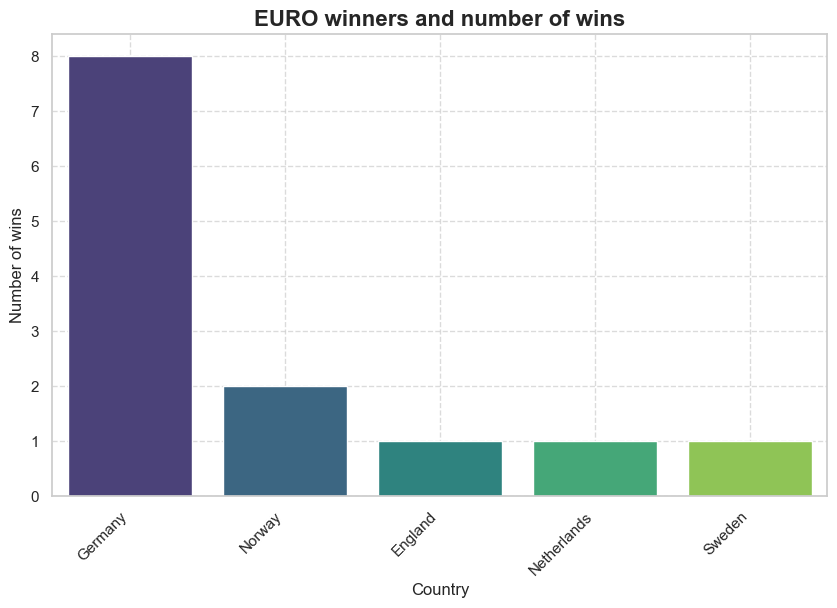

In [54]:
# Set the theme
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))  # Set plot size
bar_plot = sns.barplot(x='winner', y='wins', data=euros_df, palette='viridis')

# Add titles and labels
plt.title("EURO winners and number of wins", fontsize=16, fontweight='bold')
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of wins", fontsize=12)

# Rotate x-axis labels to make them readable if needed
plt.xticks(rotation=45, ha='right')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)


Germany is the country with more wins in the UEFA Women's Euro Championship with 8 titles. 

UEFA Women's EURO 2025 will be played in 2025 in Switzerland with 15 other nations joining the hosts.

### Engineering some features 

#### Split the dataset into training and testing sets

In [55]:
df.head()

date    home_team    away_team  home_score  away_score  \
0 1956-09-23      Germany  Netherlands         2.0         1.0   
1 1957-07-28      Germany      England         1.0         1.0   
2 1957-10-13      Germany  Netherlands         2.0         0.0   
3 1957-11-03  Netherlands      Austria         8.0         1.0   
4 1957-11-03      Germany      England         0.0         4.0   

              tournament       city  country  neutral  year  home_victory  \
0               Friendly      Essen  Germany        0  1956             1   
1               Friendly  Stuttgart  Germany        0  1957             0   
2               Friendly     Berlin  Germany        0  1957             1   
3  European Championship     Berlin  Germany        1  1957             1   
4  European Championship     Berlin  Germany        0  1957             0   

   away_victory  
0             0  
1             0  
2             0  
3             0  
4             1

In [56]:
# List of tournaments to include
tournaments = ['FIFA World Cup', 'UEFA Euro','UEFA Euro qualification', 'FIFA World Cup qualification']

# Filter the dataframe
df_ml = df[df['tournament'].isin(tournaments)]

In [57]:
# Filter only relevant columns (remove columns that leak information like scores)
df_ml = df_ml[['home_team', 'away_team', 'tournament', 'neutral', 'year', 'home_victory', 'away_victory']]

# Split into training and testing datasets
train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)

#### Tournament Importance

In [58]:
tournament_importance = {
    'FIFA World Cup': 5,
    'UEFA Euro': 4,
    'FIFA World Cup qualification': 3,
    'UEFA Euro qualification': 2
}
train_df['tournament_importance'] = train_df['tournament'].map(tournament_importance)
test_df['tournament_importance'] = test_df['tournament'].map(tournament_importance)

#### Venue Advantage

I use the neutral column to indicate whether the game is played at a neutral venue.

In [59]:
train_df['venue_advantage'] = 1 - train_df['neutral']
test_df['venue_advantage'] = 1 - test_df['neutral']

By doing this, I can directly use the new column as a feature in a machine learning model, where higher values indicate the presence of a home advantage.

#### Team strengths: win rate

In [63]:
# Calculate win rates from the training set only
team_wins = train_df['home_team'][train_df['home_victory'] == 1].value_counts() + \
                  train_df['away_team'][train_df['away_victory'] == 1].value_counts()

team_games = train_df['home_team'].value_counts() + train_df['away_team'].value_counts()
team_win_rate = team_wins/ team_games

# Map win rates to both training and testing data
train_df['home_team_win_rate'] = train_df['home_team'].map(team_win_rate)
train_df['away_team_win_rate'] = train_df['away_team'].map(team_win_rate)

test_df['home_team_win_rate'] = test_df['home_team'].map(team_win_rate)
test_df['away_team_win_rate'] = test_df['away_team'].map(team_win_rate)

In [64]:
train_df.isnull().sum()

home_team                  0
away_team                  0
tournament                 0
neutral                    0
year                       0
home_victory               0
away_victory               0
tournament_importance      0
venue_advantage            0
home_team_win_rate       122
away_team_win_rate       142
dtype: int64

The null values are likely appearing because some teams in the home_team or away_team columns of my dataset are not present in the team_win_rate dictionary. This can happen for a few reasons:

- Teams with no wins: If a team hasn't won any games in the training set, it won't have a win rate in team_win_rate.
- Teams not in training set: Some teams in the test set may not appear in the training set at all, resulting in missing mappings.
- Missing or incorrect Data: If a team is missing or there are inconsistencies in team names (e.g., typos or case sensitivity), those teams will not match the keys in team_win_rate.

One solution: give those rows the average_win_rate

In [65]:
average_win_rate = team_win_rate.mean()
average_win_rate

0.38533021252937005

In [66]:
train_df['home_team_win_rate'] = train_df['home_team'].map(team_win_rate).fillna(average_win_rate)
train_df['away_team_win_rate'] = train_df['away_team'].map(team_win_rate).fillna(average_win_rate)

test_df['home_team_win_rate'] = test_df['home_team'].map(team_win_rate).fillna(average_win_rate)
test_df['away_team_win_rate'] = test_df['away_team'].map(team_win_rate).fillna(average_win_rate)

In [67]:
train_df.isnull().sum()

home_team                0
away_team                0
tournament               0
neutral                  0
year                     0
home_victory             0
away_victory             0
tournament_importance    0
venue_advantage          0
home_team_win_rate       0
away_team_win_rate       0
dtype: int64

No NaN values

In [68]:
# Define features and target
features = ['home_team_win_rate', 'away_team_win_rate', 'tournament_importance', 'venue_advantage']
target = 'home_victory'

# Separate features and target
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

### Train the logistic model

In [69]:
# Instantiate a Logistic Regression model
logreg = LogisticRegression()

# Train the model on the training dataset
logreg.fit(X_train, y_train)


# Evaluate the model on the testing dataset
logreg.score(X_test, y_test)

0.7833333333333333

The accuracy score is the proportion of correctly predicted outcomes compared to the total number of predictions.

### Prediction: Spain vs England at the Euros 2025

In [70]:
team_win_rate_train['Spain']

0.46923076923076923

In [72]:
team_win_rate_train['England']

0.7077922077922078

In [73]:
# Predict a value for a game England vs Spain in the Euros 2025
new_game = pd.DataFrame(columns=X_train.columns)
new_game.loc[0]= [0.46923076923076923, 0.7077922077922078, 4, 0]
new_game

home_team_win_rate  away_team_win_rate  tournament_importance  \
0            0.469231            0.707792                    4.0   

   venue_advantage  
0              0.0

In [79]:
prediction = logreg.predict(new_game)[0]
prediction

0

In [75]:
probability = logreg.predict_proba(new_game)
probability

array([[0.88004934, 0.11995066]])

There's a 88% probability that the game belongs to class 0 (not a home victory). 

My model predicts with a 0.7077 accuracy that England will beat Spain at the Euros 2025.

This model has limitations:

- It is based on historical data which isn't necessarily the best way to determine how good a team is today. For example, Spain has improved a lot in the last 10 years so historical data will not provide an accurate prediction.

- We have used the average win rate for lots of missing values.

I would love to further explore this dataset when I have more knowledge about Machine Learning Models.